In [17]:
!pip install catboost
!pip install hyperopt

  Running setup.py bdist_wheel for hyperopt: started
  Running setup.py bdist_wheel for hyperopt: finished with status 'done'
  Stored in directory: C:\Users\User\AppData\Local\pip\Cache\wheels\4b\0f\9d\1166e48523d3bf7478800f250b0fceae31ac6a08b8a7cca820
  Running setup.py bdist_wheel for future: started
  Running setup.py bdist_wheel for future: finished with status 'done'
  Stored in directory: C:\Users\User\AppData\Local\pip\Cache\wheels\c2\50\7c\0d83b4baac4f63ff7a765bd16390d2ab43c93587fac9d6017a
Successfully built hyperopt future


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('ggplot') 
import seaborn as sns
from catboost import Pool, CatBoostClassifier, cv, CatboostIpythonWidget
from sklearn import preprocessing

hr_df = pd.read_csv("HR_dataset_generated_label.csv")

rAttrList = ['Department', 'OverTime', 'HourlyRate',
             'StockOptionLevel', 'DistanceFromHome',
             'YearsInCurrentRole', 'Age']

#keep only the attribute list on rAttrList
copy_hr_df = hr_df.copy(deep = True)
for col in range(0, hr_df.shape[1]):
    if hr_df.columns[col] not in rAttrList:
        copy_hr_df.drop(hr_df.columns[col], axis = 1, inplace = True)
copy_hr_df['OverTime'].replace(to_replace=dict(Yes = 1, No = 0), inplace = True)

#convert continous attribute DistanceFromHome to Catergorical
#: 1: near, 2: mid distance, 3: far
maxValues = copy_hr_df['DistanceFromHome'].max()
minValues =copy_hr_df['DistanceFromHome'].min()
intervals = (maxValues - minValues)/3
bins = [0, (minValues + intervals), (maxValues - intervals), maxValues]
groupName = [1, 2, 3]
copy_hr_df['CatDistanceFromHome'] = pd.cut(copy_hr_df['DistanceFromHome'], bins, labels = groupName)
# convert col type from cat to int64
copy_hr_df['CatDistanceFromHome'] = pd.to_numeric(copy_hr_df['CatDistanceFromHome']) 
copy_hr_df.drop(['DistanceFromHome'], axis = 1, inplace = True)

#replace department into 0 & 1, 0: R&D, and 1: Non-R&D
copy_hr_df['Department'].replace(['Research & Development', 'Human Resources', 'Sales'],
                                  [0, 1, 1], inplace = True)
print(copy_hr_df.dtypes)
#normalise data
hr_df_norm = (copy_hr_df - copy_hr_df.min()) / (copy_hr_df.max() - copy_hr_df.min())

#create a data frame for the function value and class labels
value_df = pd.DataFrame(columns = ['ClassValue'])
#compute the class value
for row in range (0, hr_df.shape[0]):
    if hr_df_norm['Department'][row] == 0:
        value = 0.3 * hr_df_norm['HourlyRate'][row] - 0.2 * hr_df_norm['OverTime'][row] + \
            - 0.2 * hr_df_norm['CatDistanceFromHome'][row] + 0.15 * hr_df_norm['StockOptionLevel'][row] + \
            0.1 * hr_df_norm['Age'][row] - 0.05 * hr_df_norm['YearsInCurrentRole'][row]
    
    else:
        value = 0.2 * hr_df_norm['HourlyRate'][row] - 0.3 * hr_df_norm['OverTime'][row] + \
            - 0.15 * hr_df_norm['CatDistanceFromHome'][row] + 0.2 * hr_df_norm['StockOptionLevel'][row] + \
            0.05 * hr_df_norm['Age'][row] - 0.1 * hr_df_norm['YearsInCurrentRole'][row]
    value_df.loc[row] = value

# top 500 highest class value is satisfied with their job
v1 = value_df.sort_values('ClassValue', ascending = False).reset_index(drop = True)\
        ['ClassValue'][499]
# next top 500 is neutral
v2 = value_df.sort_values('ClassValue', ascending = False).reset_index(drop = True)\
        ['ClassValue'][999]
# rest is unsatisfied

label_df = pd.DataFrame(columns = ['ClassLabel'])
#compute the classlabel
for row in range (0, value_df.shape[0]):
    if value_df['ClassValue'][row] >= v1:
        cat = "Satisfied"
    elif value_df['ClassValue'][row] >= v2:
        cat = "Neutral"
    else:
        cat = "Unsatisfied"
    label_df.loc[row] = cat

class_df = pd.concat([value_df, label_df], axis = 1)



Age                    int64
Department             int64
HourlyRate             int64
OverTime               int64
StockOptionLevel       int64
YearsInCurrentRole     int64
CatDistanceFromHome    int64
dtype: object


In [15]:
df = pd.read_csv("HR_dataset_generated_label.csv")
df.dtypes
df = df[['Age', 'Department', 'DistanceFromHome', 'HourlyRate', 'OverTime', 'StockOptionLevel', 'YearsInCurrentRole', 'MaritalStatus', 'EmployeeNumber', 'ClassLabel']]
df['OverTime'].replace(to_replace=dict(Yes=1, No=0), inplace=True)

X = df.drop('ClassLabel', axis=1)
y = df.ClassLabel
y.replace(to_replace=dict(Satisfied=2, Netural=1, Unsatisfied=0), inplace=True)

one_hot = pd.get_dummies(X)
#df_norm = (df - df.mean()) / (df.max() - df.min())
one_hot = (one_hot - one_hot.mean()) / (one_hot.max() - one_hot.min())
categorical_features_indices = np.where(one_hot.dtypes != np.float)[0]

In [16]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(one_hot, y, train_size=0.7, random_state=1234)

model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=100,
    loss_function='MultiClass'
)

model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = True,  # you can uncomment this for text output
    plot = True
)




Borders for float features generated
0:	learn -1.078390607	total: 16.2ms	remaining: 8.07s
1:	learn -1.053214296	total: 40.9ms	remaining: 10.2s
2:	learn -1.028820622	total: 61.3ms	remaining: 10.2s
3:	learn -1.005141951	total: 80.4ms	remaining: 9.97s
4:	learn -0.9839593493	total: 94.4ms	remaining: 9.35s
5:	learn -0.9635995497	total: 112ms	remaining: 9.18s
6:	learn -0.9417636042	total: 129ms	remaining: 9.09s
7:	learn -0.9217437513	total: 151ms	remaining: 9.26s
8:	learn -0.903489603	total: 170ms	remaining: 9.25s
9:	learn -0.8857370351	total: 189ms	remaining: 9.27s
10:	learn -0.8679553298	total: 210ms	remaining: 9.31s
11:	learn -0.8508607818	total: 227ms	remaining: 9.25s
12:	learn -0.8372541291	total: 246ms	remaining: 9.2s
13:	learn -0.8238570069	total: 259ms	remaining: 8.98s
14:	learn -0.8103213365	total: 279ms	remaining: 9.03s
15:	learn -0.7977769624	total: 299ms	remaining: 9.04s
16:	learn -0.7824112596	total: 317ms	remaining: 9.01s
17:	learn -0.7696178008	total: 336ms	remaining: 9s
18:	l

In [17]:
model.get_feature_importance(Pool(one_hot, label=y, cat_features=categorical_features_indices))

[2.5680650464686825,
 17.800672520388538,
 25.121671118168752,
 32.22679968860254,
 9.487875377751477,
 2.31095935617173,
 0.6391319792669126,
 0.11471728695546211,
 5.639856898959755,
 2.213225299052888,
 0.6844202407074808,
 0.16248690166677762,
 1.030118285838999]

In [18]:
feature_score = pd.DataFrame(list(zip(one_hot.dtypes.index, model.get_feature_importance(Pool(one_hot, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

In [19]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

In [20]:
feature_score

,Feature,Score
3,OverTime,32.226800
2,HourlyRate,25.121671
1,DistanceFromHome,17.800673
4,StockOptionLevel,9.487875
8,Department_Research & Development,5.639857
0,Age,2.568065
5,YearsInCurrentRole,2.310959
9,Department_Sales,2.213225
12,MaritalStatus_Single,1.030118
10,MaritalStatus_Divorced,0.684420


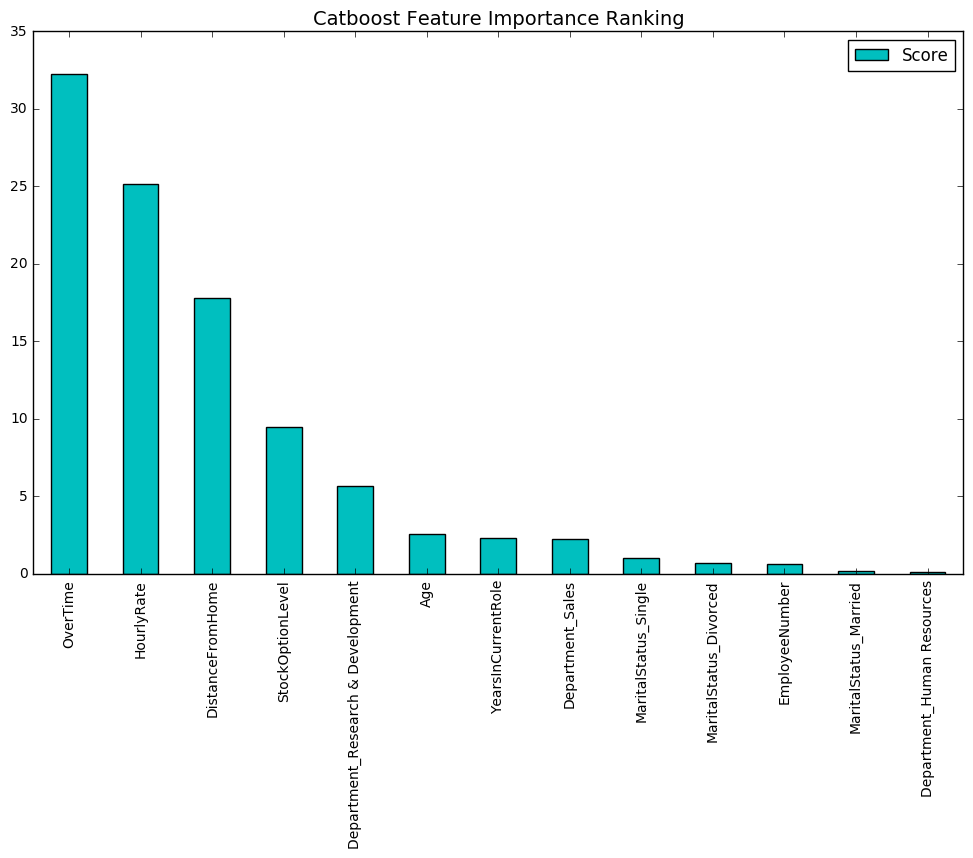

In [21]:
#Plotting
plt.rcParams["figure.figsize"] = (12,7)
feature_score.plot('Feature', 'Score', kind='bar', color='c')
plt.title("Catboost Feature Importance Ranking", fontsize = 14)
plt.xlabel('')
plt.show()

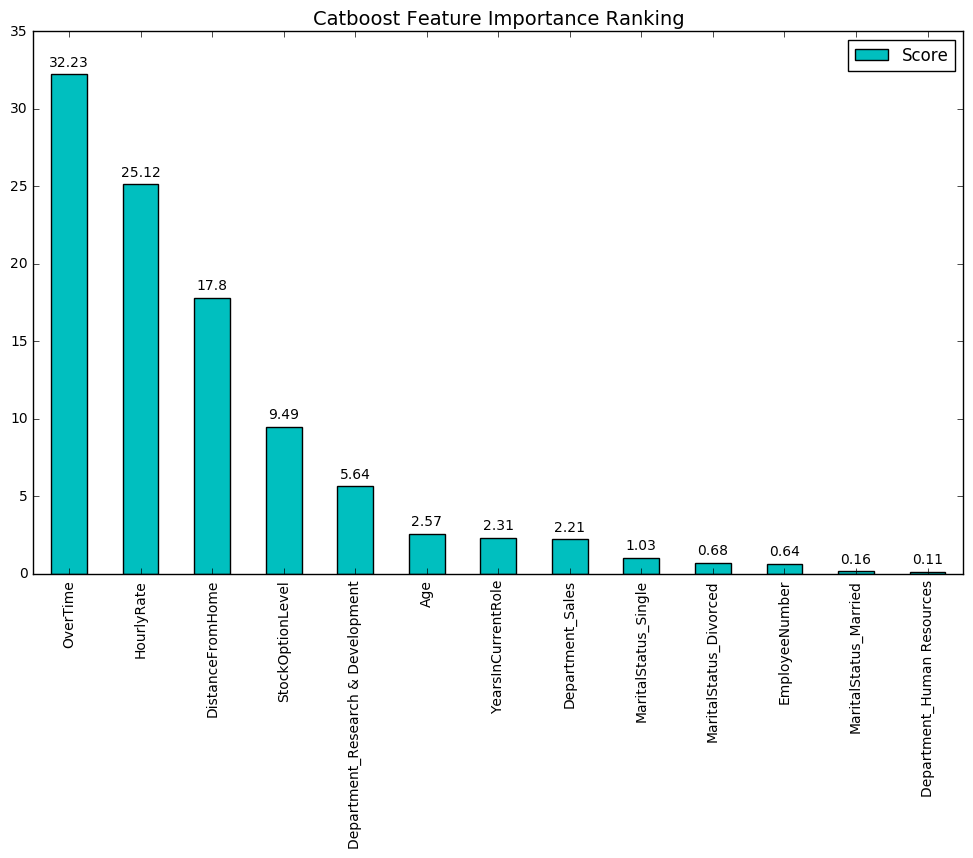

In [22]:
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels round to 2 decimal
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()
#plt.savefig("image.png")

In [23]:
cm = pd.DataFrame()
cm['Satisfaction'] = y_test
cm['Predict'] = model.predict(X_test)

In [24]:
mappingSatisfaction = {0:'Unsatisfied', 1: 'Neutral', 2: 'Satisfied'}
mappingPredict = {0.0:'Unsatisfied', 1.0: 'Neutral', 2.0: 'Satisfied'}
cm = cm.replace({'Satisfaction': mappingSatisfaction, 'Predict': mappingPredict})

In [25]:
pd.crosstab(cm['Satisfaction'], cm['Predict'], margins=True)

Predict,Neutral,Satisfied,Unsatisfied,All
Satisfaction,,,,
Neutral,146,11,2,159
Satisfied,7,137,0,144
Unsatisfied,8,0,130,138
All,161,148,132,441


In [26]:
model.score(X_test, y_test)

0.93650793650793651